In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
from skimage.io import imread

waterfall = imread ('https://s3-us-west-2.amazonaws.com/uw-s3-cdn/wp-content/uploads/sites/6/2017/11/04133712/waterfall.jpg')
nature = imread ('http://www.youandthemat.com/wp-content/uploads/nature-2-26-17.jpg')
bridge = imread ('https://buddhisteconomics.net/wp-content/uploads/2017/10/hdwp693968124.jpg')
skyline = imread ('https://upload.wikimedia.org/wikipedia/commons/d/dc/Skyscrapers_of_Shinjuku_2009_January_%28revised%29.jpg')
toranto = imread ('https://www.worldatlas.com/r/w728-h425-c728x425/upload/db/04/18/toronto-ontario.jpg')
gate = imread ('https://www.valdosta.edu/academics/online-programs/images/slideshow-new-vsu-arch.jpg')
fountain = imread ('https://www.valdosta.edu/administration/planning/images/planningimage.jpg')
centen = imread ('http://www.carterusa.com/project-images/develop/program-Project-Management/higher-education/Valdosta-State-Student-Housing/gal-1.JPG')


# normalize images 
waterfall = waterfall / 255.0
nature = nature / 255.0
bridge = bridge / 255.0
skyline = skyline / 255.0
toranto = toranto / 255.0
gate = gate / 255.0
fountain = fountain / 255.0
centen = centen / 255.0

#images = [waterfall, nature, bridge, skyline, toranto, gate, fountain, centen]
images = [waterfall]

In [0]:
# Flatten array and turn into data frame
def image_to_df(im):
  im = np.reshape(im, (im.shape[0] * im.shape[1], im.shape[2]))
  df = pd.DataFrame.from_records(im)
  df.columns = ['r', 'g', 'b']
  return df

# get centroids 
def get_centroids(im, k):
  r, c, clr  = im.shape
  centroids = {i+1: im[(np.random.randint(0, r - 1)), (np.random.randint(0, c - 1))] for i in range(k)}
  return r, c, centroids

# this function returns the r_{nk}
def assignment(df, centroids):
  for i in centroids.keys():
    df['distance_from_{}'.format(i)] = (np.sqrt(   ((df['r'] - centroids[i][0])**2) + 
                                                   ((df['g'] - centroids[i][1])**2) +
                                                   ((df['b'] - centroids[i][2])**2)))
  centroid_distance_cols = ['distance_from_{}'.format(i) for i in centroids.keys()]
  df['closest'] = df.loc[:, centroid_distance_cols].idxmin(axis=1)
  df['closest'] = df['closest'].map(lambda x: int(x.lstrip('distance_from_')))
  return df

# update centroids 
def update(df, centroids):
  updated_centroids = {}
  for i in centroids.keys():
    if(True not in df['closest'] == i):
      continue
    else:
      updated_centroids[i] = np.mean(df[df['closest'] == i])
  return updated_centroids

def maximization(df, centroids):
  it = 0
  costs = []
  centroid_distance_cols = ['distance_from_{}'.format(i) for i in centroids.keys()]
  while it < 25:
    # E - step
    centroids = update(df, centroids) 
    # M - step
    df = assignment(df, centroids)
    cost = df.loc[:,  centroid_distance_cols].min(axis=1).sum()
    if(len(costs)==0 or costs[-1]!=cost):
      costs.append(cost)
    else:
      break
    it+=1
    return df, costs, centroids

# Replace each pixel(r,g,b) value in each row
def replace_pixels(df, centroids):
  for ix, row in df.iterrows():
    color = centroids[row['closest']]
    df.at[ix,'r'] = color[0]
    df.at[ix,'g'] = color[1]
    df.at[ix,'b'] = color[2]
  return df

# Return df to image
def df_to_im(df, im):
  df = df.filter(['r','g','b'], axis=1)
  df = df.to_numpy()
  new_im = np.reshape(df, (im.shape[0], im.shape[1], im.shape[2]))
  return new_im

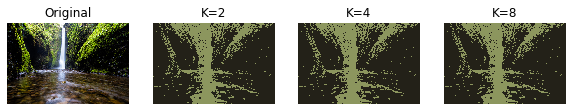

In [3]:
K = [2, 4, 8]

for im in images:
  plot_images = []
  plot_images.append(im)
  df = image_to_df(im)
  for k in K:
    r, c, centroids = get_centroids(im, k)
    new_df = assignment(df , centroids)
    max_df, costs, new_centroids = maximization(new_df, centroids)
    new_image = replace_pixels(max_df, new_centroids)
    plot_images.append(df_to_im(new_image, im))
   
  fig, ax = plt.subplots(1, 4, figsize=(10, 10))
  ax[0].imshow(plot_images[0]), ax[0].axis('off'), ax[0].set_title('Original')
  ax[1].imshow(plot_images[1]), ax[1].axis('off'), ax[1].set_title('K=2')
  ax[2].imshow(plot_images[2]), ax[2].axis('off'), ax[2].set_title('K=4') 
  ax[3].imshow(plot_images[3]), ax[3].axis('off'), ax[3].set_title('K=8') 

In [5]:
k2 = 4
r, c, centroids = get_centroids(nature, k2)
df = new_df
new_df

,r,g,b,distance_from_1,distance_from_2,closest,distance_from_3,distance_from_4,distance_from_5,distance_from_6,distance_from_7,distance_from_8
0,0.137411,0.132061,0.096877,NaN,NaN,8,NaN,NaN,0.675469,NaN,NaN,2.271226e-12
1,0.137411,0.132061,0.096877,NaN,NaN,8,NaN,NaN,0.675469,NaN,NaN,2.271226e-12
2,0.137411,0.132061,0.096877,NaN,NaN,8,NaN,NaN,0.675469,NaN,NaN,2.271226e-12
3,0.137411,0.132061,0.096877,NaN,NaN,8,NaN,NaN,0.675469,NaN,NaN,2.271226e-12
4,0.137411,0.132061,0.096877,NaN,NaN,8,NaN,NaN,0.675469,NaN,NaN,2.271226e-12
...,...,...,...,...,...,...,...,...,...,...,...,...
2795515,0.137411,0.132061,0.096877,NaN,NaN,8,NaN,NaN,0.675469,NaN,NaN,2.271226e-12
2795516,0.137411,0.132061,0.096877,NaN,NaN,8,NaN,NaN,0.675469,NaN,NaN,2.271226e-12
2795517,0.137411,0.132061,0.096877,NaN,NaN,8,NaN,NaN,0.675469,NaN,NaN,2.271226e-12
2795518,0.137411,0.132061,0.096877,NaN,NaN,8,NaN,NaN,0.675469,NaN,NaN,2.271226e-12
